In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf

In [2]:
reconstructed_model = tf.keras.models.load_model("./tf_model")

In [3]:
data_import = pd.read_csv('../Data/SQLout_employees.csv')

In [4]:
data_import.columns

Index(['year', 'nace', 'key_l', 'key_e', 'location', 'esize_class',
       'collective', 'gender', 'age_class', 'lpk', 'education', 'experience',
       'arrangement', 'work_part', 'contract', 'weeks', 'hours', 'overtime',
       'vacation', 'gross_salary', 'bonuses', 'total', 'gross_salary_oct',
       'bonuses_oct', 'bonuses_add_oct', 'total_oct', 'hourly_rate', 'weight'],
      dtype='object')

In [5]:
def observations_between_thresholds(df, lower_threshold=0.05, upper_threshold=0.95):
    """Select observations, with hourly rate between
     thresholds for lpk groups. Thresholds are defined by quantile"""
    df['rank'] = df.groupby('lpk')['hourly_rate'].rank(pct=True).copy()
    df = df.query('rank < @upper_threshold & rank > @lower_threshold')
    df = df.drop(columns='rank')     
    return df

In [6]:
data2018ft = data_import.query('arrangement == "FT" & year==2018', inplace=False )[['nace', 
                          'esize_class', 'gender', 
                          'age_class', 'lpk',  'education','experience', 'hourly_rate']]

data2018ft.shape

(36785, 8)

In [7]:
upper_threshold = 0.80
lower_threshold = 0.10

data=data2018ft.copy()
data = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
data = data.rename(columns={'hourly_rate': 'target'})
data = data.groupby('lpk').filter(lambda x: len(x) > 50)
data['lpk'] = data['lpk'].apply(str)
data.shape

(25197, 8)

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [14]:
start = 1
length = 20000

In [15]:
batch_size = 256
data_for_prediction = df_to_dataset(data.iloc[start:start+length],  shuffle=False, batch_size=batch_size)
data_for_prediction

<PrefetchDataset element_spec=({'nace': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'esize_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'age_class': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'lpk': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'experience': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [16]:
predict = reconstructed_model.predict(data_for_prediction)


79/79 [==============================] - 0s 1ms/step


In [17]:
from sklearn.metrics import r2_score
print('Test: R2=', r2_score(data.target.iloc[start:start+length].to_numpy(), predict.ravel()).round(3))

Test: R2= 0.699


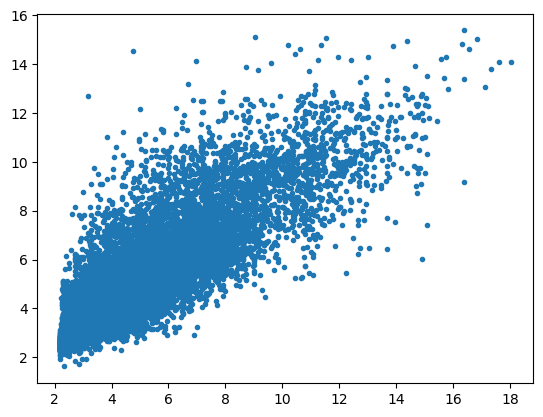

In [18]:
plt.plot(data.target.iloc[start:start+length].to_numpy(), predict.ravel(), ".");